<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing
A notebook for testing an exported model. Ideally, this can be considered a part of a model evaluation pipeline, in which a model can be evaluated in greater depth. 

## Setup

### Notebook Setup 

In [ ]:
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [ ]:
from fastai.vision.all import *
from google.colab import drive
#from scipy import stats
from sklearn.metrics import mean_squared_error

import numpy as np 
import os 
import pandas as pd

drive.mount('/content/drive')

In [ ]:
%rm -rf /content/fyp/

In [2]:
# Import fyputil library
%cd /content
!git clone https://github.com/WRFitch/fyp.git
%cd fyp/src/fyputil
import constants as c
import fyp_utils as fyputil
%cd /content

/content
Cloning into 'fyp'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (283/283), done.
remote: Total 854 (delta 222), reused 109 (delta 59), pack-reused 512
Receiving objects: 100% (854/854), 146.08 MiB | 36.04 MiB/s, done.
Resolving deltas: 100% (477/477), done.
/content/fyp/src/fyputil
/content


### Data Setup 

In [6]:
# Add a dummy label script to fool fastai into letting us import the model. 
# We're not going to train the model further, so this is fine. 
def getGhgsAsArr(img_path):
  return np.array()

model = load_learner(f"{c.model_dir}/mrghg_fullnorm.pkl")

def normGhgDf(ghg_df):
  for band in c.ghg_bands:
    max = ghg_df[band].max()
    min = ghg_df[band].min()
    ghg_df[band] = ghg_df[band].apply(lambda x: (x-min)/(max-min) * 100)
  return ghg_df


In [7]:
ghg_df = pd.read_csv(c.ghg_csv)
ghg_df = normGhgDf(ghg_df)
ghg_df

,Unnamed: 0,system:index,SO2_column_number_density,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density
0,134,0_134,37.059645,-0.795009,51.118631,19.607470,33.377361,6.603347,4.773004,15.388263
1,135,0_135,32.874369,-0.786026,51.118631,18.383528,30.641076,8.903884,5.345012,14.434940
2,136,0_136,38.575800,-0.777043,51.118631,16.526009,32.553934,6.237494,3.764341,9.809938
3,137,0_137,46.757106,-0.768060,51.118631,8.346549,31.724441,4.383772,3.134054,5.152530
4,138,0_138,48.375586,-0.759076,51.118631,13.259975,29.757876,9.120335,3.250394,4.019683
...,...,...,...,...,...,...,...,...,...,...
1881,4147,0_4147,28.982110,0.345851,51.379143,48.730023,51.676159,40.240712,52.492478,82.988492
1882,4148,0_4148,29.317961,0.354835,51.379143,69.944322,55.563051,33.433213,51.374351,83.640236
1883,4149,0_4149,32.202132,0.363818,51.379143,51.965457,67.081132,44.057710,52.922176,84.070751
1884,4150,0_4150,37.128438,0.372801,51.379143,51.965438,63.214312,47.319044,50.743240,82.580199


In [34]:
err_headers = [c.lon, c.lat] + c.ghg_bands
errors = pd.DataFrame(columns = err_headers)
errors.iloc[0:1]

,longitude,latitude,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density,SO2_column_number_density,CH4_column_volume_mixing_ratio_dry_air


## Testing

### Test model against existing data 

In [9]:
print(c.ghg_bands)

# TODO replace with fyputil, OR re-implement to keep any failed measurements and
# evaluate what you can out of them. Just because they're incomplete, that 
# doesn't necessarily make them worthless 
def getGhgs(img_path, df): 
  coords = fyputil.getCoords(str(img_path))
  ghgs = fyputil.getValAt(coords, df)
  concentrations = ghgs[c.ghg_bands]
  if len(concentrations) == 0 : return None 
  if None in concentrations: return None
  # There has to be a cleaner way to do this. Iterating through and then only getting the first line? really? 
  return [tuple(x) for x in concentrations.to_numpy()][0]

['CO_column_number_density', 'tropospheric_HCHO_column_number_density', 'tropospheric_NO2_column_number_density', 'O3_column_number_density', 'SO2_column_number_density', 'CH4_column_volume_mixing_ratio_dry_air']


In [ ]:
# Dumb & easy method of splitting data so I don't have to analyse every image 
# every time I want to smell test something. 
mod = 0 

for filename in os.listdir(c.png_dir):
  file_ghgs = getGhgs(filename, ghg_df)
  if file_ghgs == None: continue
  if mod % 1 == 0:
    print(f"predicting ghg gases at {filename}")
    coords = fyputil.getCoords(filename) 
    prediction = model.predict(f"{c.png_dir}/{filename}")[0]

    diffs = [pred - act for pred, act in zip(prediction, file_ghgs)]
    errors.loc[len(errors)] = list(coords) + diffs

    print(tuple(coords))
    print(prediction)
    print(file_ghgs)
    print(diffs)
    print()
  mod += 1 



In [36]:
errors 

,longitude,latitude,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density,SO2_column_number_density,CH4_column_volume_mixing_ratio_dry_air
0,-0.786026,51.343210,34.780681,0.495471,-7.229596,20.276040,-24.275605,30.521075
1,-0.768060,51.343210,18.567693,8.349823,-10.631210,15.994145,-12.403878,23.564330
2,-0.777043,51.343210,25.598599,7.999066,-4.569027,13.191092,-10.798261,21.261308
3,-0.759076,51.343210,7.220048,-12.330770,-21.044270,8.821175,-12.813489,22.255440
4,-0.750093,51.343210,7.745313,-10.422311,-13.748740,11.150787,-13.707040,21.718842
...,...,...,...,...,...,...,...,...
1881,0.318902,51.262362,12.501120,7.305895,5.545148,10.271046,-5.276064,-0.754419
1882,0.354835,51.262362,-17.864182,6.350734,-13.088325,-0.281496,-6.758601,-18.298079
1883,0.372801,51.262362,-11.512303,5.440105,-5.175598,0.691628,-7.021751,-17.442688
1884,0.363818,51.262362,-6.594223,15.546702,-13.917822,1.496015,-1.525621,-14.212026


In [53]:
errors.to_csv(f"{c.data_dir}/errors_norm.csv")

### Basic stat testing 
- Data exploration 
- RMSE per GHG
- Extract outliers & view images 

In [ ]:
errors = pd.read_csv(f"{c.data_dir}/errors_norm.csv")

In [38]:
model_stats = pd.DataFrame(columns = ["stat"] + c.ghg_bands)

In [13]:
def getRmse(series): 
  return np.sqrt(np.mean(series**2))

In [40]:
# Define aggregate metrics 
# TODO remove multiple iterations through errors, improve bigO 
means = [errors[ghg].mean() for ghg in c.ghg_bands ]
stdevs = [errors[ghg].std() for ghg in c.ghg_bands ]
rmse = [getRmse(errors[ghg]) for ghg in c.ghg_bands ]
mae = [errors[ghg].abs().mean() for ghg in c.ghg_bands ]

model_stats.loc[1] = ["Mean"] + means
model_stats.loc[2] = ["Standard Deviation"] + stdevs 
model_stats.loc[3] = ["RMSE"] + rmse
model_stats.loc[4] = ["MAE"] + mae

In [41]:
model_stats

,stat,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density,SO2_column_number_density,CH4_column_volume_mixing_ratio_dry_air
1,Mean,-0.401066,-0.225506,-1.252926,0.867189,0.756036,-1.342584
2,Standard Deviation,15.109546,16.993505,16.255879,14.428115,16.041854,14.710859
3,RMSE,15.110863,16.990496,16.299795,14.450333,16.055411,14.768113
4,MAE,11.774294,13.157876,12.878742,10.546847,12.489943,11.338034


#### Plot raw stats 

In [43]:
# Merge ghg and recalculate predictions 
combi_df = ghg_df.merge(errors, how="inner", on=[c.lon, c.lat], suffixes=("_orig", "_err"))
for ghg in c.ghg_bands:
  combi_df[f"{ghg}_pred"] = combi_df[f"{ghg}_orig"] + combi_df[f"{ghg}_err"]


In [44]:
combi_df

,Unnamed: 0,system:index,SO2_column_number_density_orig,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air_orig,CO_column_number_density_orig,tropospheric_HCHO_column_number_density_orig,tropospheric_NO2_column_number_density_orig,O3_column_number_density_orig,CO_column_number_density_err,tropospheric_HCHO_column_number_density_err,tropospheric_NO2_column_number_density_err,O3_column_number_density_err,SO2_column_number_density_err,CH4_column_volume_mixing_ratio_dry_air_err,CO_column_number_density_pred,tropospheric_HCHO_column_number_density_pred,tropospheric_NO2_column_number_density_pred,O3_column_number_density_pred,SO2_column_number_density_pred,CH4_column_volume_mixing_ratio_dry_air_pred
0,134,0_134,37.059645,-0.795009,51.118631,19.607470,33.377361,6.603347,4.773004,15.388263,5.968124,40.289491,24.345281,31.920808,16.882917,12.773931,39.345486,46.892838,29.118284,47.309071,53.942562,32.381401
1,135,0_135,32.874369,-0.786026,51.118631,18.383528,30.641076,8.903884,5.345012,14.434940,4.245803,36.717717,15.314325,25.018548,24.315191,10.883625,34.886879,45.621601,20.659336,39.453487,57.189560,29.267153
2,136,0_136,38.575800,-0.777043,51.118631,16.526009,32.553934,6.237494,3.764341,9.809938,-2.141455,36.598569,13.467890,32.588237,14.532522,12.669729,30.412479,42.836063,17.232231,42.398174,53.108322,29.195738
3,137,0_137,46.757106,-0.768060,51.118631,8.346549,31.724441,4.383772,3.134054,5.152530,-3.510448,38.654524,14.326038,34.605287,7.845196,17.202994,28.213993,43.038296,17.460093,39.757816,54.602303,25.549543
4,138,0_138,48.375586,-0.759076,51.118631,13.259975,29.757876,9.120335,3.250394,4.019683,5.051507,34.220832,26.092887,44.938801,-0.653327,11.681185,34.809383,43.341167,29.343281,48.958485,47.722260,24.941160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,4147,0_4147,28.982110,0.345851,51.379143,48.730023,51.676159,40.240712,52.492478,82.988492,17.283146,6.853896,-1.665936,-2.422917,10.477576,14.635924,68.959305,47.094608,50.826542,80.565575,39.459686,63.365948
1882,4148,0_4148,29.317961,0.354835,51.379143,69.944322,55.563051,33.433213,51.374351,83.640236,8.201598,10.795058,-12.380695,-8.200912,15.780748,-10.598707,63.764648,44.228271,38.993656,75.439323,45.098709,59.345615
1883,4149,0_4149,32.202132,0.363818,51.379143,51.965457,67.081132,44.057710,52.922176,84.070751,0.863662,0.794280,-6.179100,-4.888554,9.545274,10.907193,67.944794,44.851990,46.743076,79.182198,41.747406,62.872650
1884,4150,0_4150,37.128438,0.372801,51.379143,51.965438,63.214312,47.319044,50.743240,82.580199,-1.665083,-1.693747,-16.465824,-9.008330,9.412170,4.617250,61.549229,45.625298,34.277416,73.571869,46.540607,56.582687


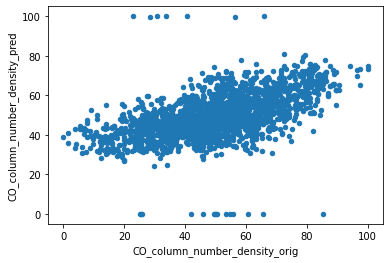

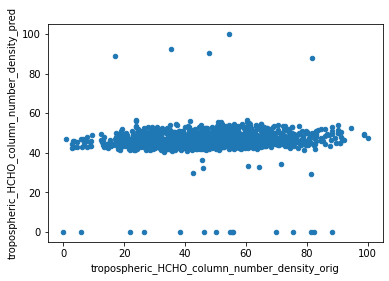

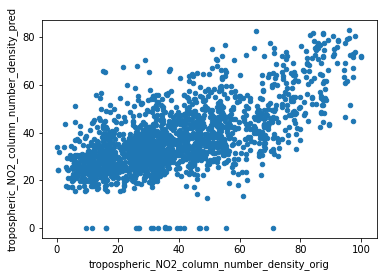

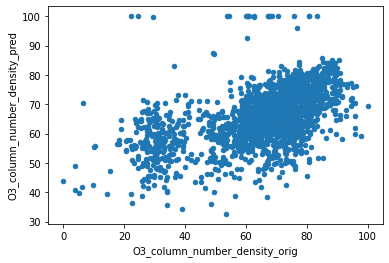

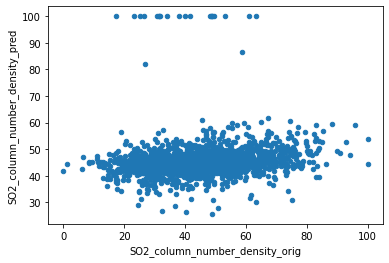

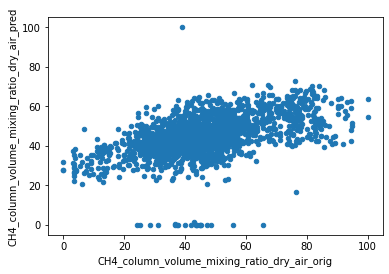

In [46]:
for ghg in c.ghg_bands:
  combi_df.plot(x = f"{ghg}_orig", y = f"{ghg}_pred", kind = "scatter")
  plt.show()

### Find and process Outliers 
- Percentile 
  - 1.5*IQR for weak outliers
  - 3*IQR for strong outliers
- Linear regression 
- Standard deviation +- 2 (or 3) 
- Normal probability plot 



In [52]:
outliers = []
for ghg in c.ghg_bands:
  ghg_outliers = []
  q1 = combi_df[f"{ghg}_err"].quantile(0.25)
  q3 = combi_df[f"{ghg}_err"].quantile(0.75)
  iqr = q3 - q1
  lbound = q1 - 1.5*iqr
  ubound = q3 + 1.5*iqr
  ghg_outliers = combi_df[((combi_df > ubound) | (combi_df < lbound)).any(axis=1)]
  outliers.append(ghg_outliers)

print(outliers)

TypeError: ignored

In [ ]:
# outliers for specific GHGs 

### Sample images vs predictions 
what regions are easier to predict than others? 

create accuracy heatmap 

## Brunel Analysis 